In [1]:
import matplotlib.pyplot as plt
def create_plots(X, Y, Z, Z1, Z2, Z3, v_x, v_y, cm='viridis'):

    fig = plt.figure(figsize=(5,15), dpi=150)

    ax1 = fig.add_subplot(4,1,1)
    ax1.set_aspect('equal')
    levels = np.linspace(min(0,np.floor(np.min(Z))),np.ceil(np.max(Z)),15)
    cntr = ax1.contourf(X, Y, Z, levels, cmap=cm)
    ax1.contour(X, Y, Z, levels, colors='w')
    ax1.set_xlabel('x')                                     
    ax1.set_ylabel('y')
    cbar = fig.colorbar(cntr)
    cbar.set_label('Stream function')
    ax1.quiver(X, Y, v_x, v_y)
                                  
    ax2 = fig.add_subplot(4,1,2)
    ax2.set_aspect('equal')
    cntr = ax2.contourf(X, Y, Z1, cmap=cm)
    ax2.set_xlabel('x')                                     
    ax2.set_ylabel('y')
    cbar = fig.colorbar(cntr)
    cbar.set_label('vorticity')
    ax2.quiver(X, Y, v_x, v_y)    
    
    ax3 = fig.add_subplot(4,1,3)
    ax3.set_aspect('equal')
    cntr = ax3.contourf(X, Y, Z2, cmap=cm)
    ax3.set_xlabel('x')                                     
    ax3.set_ylabel('y')
    cbar = fig.colorbar(cntr)
    cbar.set_label('velocity')
    ax3.quiver(X, Y, v_x, v_y)
    
    ax4 = fig.add_subplot(4,1,4)
    ax4.set_aspect('equal')
    cntr = ax4.contourf(X, Y, Z3, cmap=cm)
    ax4.set_xlabel('x')                                     
    ax4.set_ylabel('y')
    cbar = fig.colorbar(cntr)
    cbar.set_label('pressure')

    return [ax1, ax2, ax3, ax4] 

In [30]:
import numpy as np
import math

def solve_lid_driven_cavity_flow(Re = 10, u_top = 1.0, u_bottom = 0.0, box_size = 20, dt = 0.0001, t_max = 100000, it_max=1000, omega = 1.5, max_error = 0.001):
    h = 1.0 / box_size 
    
    if dt/(Re*h**2) > 0.25:
        raise Exception("dt/(Re*h^2) > 0.25 \t {}/{}*{}^2 = {}".format(dt, Re, h, dt/(Re*h**2)))
    
    def apply_vorticity_boundaries():                          
        # Left wall
        w[0, :] = 2 * (u[1, :] - u[2, :]) / h**2
            
        # Right wall
        w[box_size, :] = 2 * (u[box_size - 1, :] - u[box_size - 2, :]) / h**2

        # Bottom wall                           
        w[:, 0] = 2 * (u[:, 1] - u[:, 2]) / h**2 - 2 * u_bottom / h
            
        # Top Wall, moving
        w[:, box_size] = 2 * (u[:, box_size - 1] - u[:, box_size - 2]) / h**2 + 2 * u_top / h
    
    # Stream function, Successive over-relaxation
    def converge_stream_function():
        for it in range (0, it_max):
            u_old = u.copy()
                                                                                                      
            for i in range(1, box_size):
                for j in range (1, box_size):
                    u_ij = (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] + w[i,j]*h**2) / 4
                    u[i,j] += omega * (u_ij - u_old[i,j])
            
            error = np.sum(np.absolute(u_old - u))
            if error <= max_error:
                return
        
    def update_vorticity():
        nonlocal w
        
        apply_vorticity_boundaries()
        
        dwdt = np.zeros((box_size+1,box_size+1))
        for i in range(1, box_size):
            for j in range(1, box_size):
                dwdt[i,j] = (- ((u[i,j+1] - u[i,j-1]) / (2*h))  *  ((w[i+1,j] - w[i-1,j]) / (2*h)) \
                            + ((u[i+1,j] - u[i-1,j]) / (2*h))  *  ((w[i,j+1] - w[i,j-1]) / (2*h)) \
                            + (1/Re) * ((w[i+1,j] + w[i-1,j] + w[i,j+1] + w[i,j-1] - 4*w[i,j]) / (h**2))
                           )                             
        
        w += dwdt * dt
    
    def velocity_field():
        v = np.zeros((box_size+1,box_size+1))
        u_up = np.roll(u.copy(), 1, axis=0)
        u_down = np.roll(u.copy(), -1, axis=0)
        u_left = np.roll(u.copy(), 1, axis=1)
        u_right = np.roll(u.copy(), -1, axis=1)

        v_x = (u_left - u_right)/(2*h)
        v_y = (u_down - u_up)/(2*h)

        v = np.sqrt(v_x**2 + v_y**2)
        return v, v_x, v_y
                
    def pressure_field():
        p = np.zeros((box_size+1,box_size+1))
        C = np.zeros((box_size+1,box_size+1))
        
        for i in range(1, box_size):
            for j in range(1, box_size):
                du_x = (u[i+1, j] + u[i-1, j] - 2*u[i,j]) /(h**2)
                du_y = (u[i, j+1] + u[i, j-1] - 2*u[i,j]) /(h**2)
                du_xy= (u[i+1, j+1] - u[i+1, j-1] - u[i-1,j+1] + u[i-1,j-1]) /(4*h**2)

                C[i,j] = 2*(du_x*du_y-du_xy**2)     

        p_old = p.copy()
        while True:
            for i in range(1, box_size):
                for j in range(1, box_size):
                    p[i,j] = (p[i-1,j]+p[i+1,j]+p[i,j-1]+p[i,j+1] - C[i,j]*h**2)/4
            error = np.sum(np.absolute(p_old - p))
            if error < max_error:
                break
            p_old = p.copy()
        return -p

    # Initialize fields to 0
    u = np.zeros((box_size+1,box_size+1))
    w = np.zeros((box_size+1,box_size+1))
    v = np.zeros((box_size+1,box_size+1))
    
    # Converge untill stable solution or t_max is reached
    w_old = w.copy()
    for t in range (0, t_max):
        converge_stream_function()
        update_vorticity()
        
        error = np.sum(np.absolute(w_old - w))
        if error < max_error:
            break
        w_old = w.copy()
    
    # Put stream function in u_top h units
    u /= u_top * h

    # Properly write out the results for plotting
    x = np.arange(box_size+1)
    y = np.arange(box_size+1)
    X, Y = np.meshgrid(x,y)
    U = u[X,Y]
    W = w[X,Y]
    
    
    v, v_x, v_y = velocity_field()
    V = v[X,Y]
    
    p = pressure_field()
    P = p[X,Y]

    return X, Y, U, W, V, P, v_x.T, v_y.T


# Q1

In [ ]:
X, Y, U, W, V, P, v_x, v_y = solve_lid_driven_cavity_flow(Re=10, box_size = 100)
create_plots(X, Y, U, W, V, P, v_x, v_y)

X, Y, U, W, V, P, v_x, v_y = solve_lid_driven_cavity_flow(Re=100, box_size = 200)
create_plots(X, Y, U, W, V, P, v_x, v_y)

# Q2

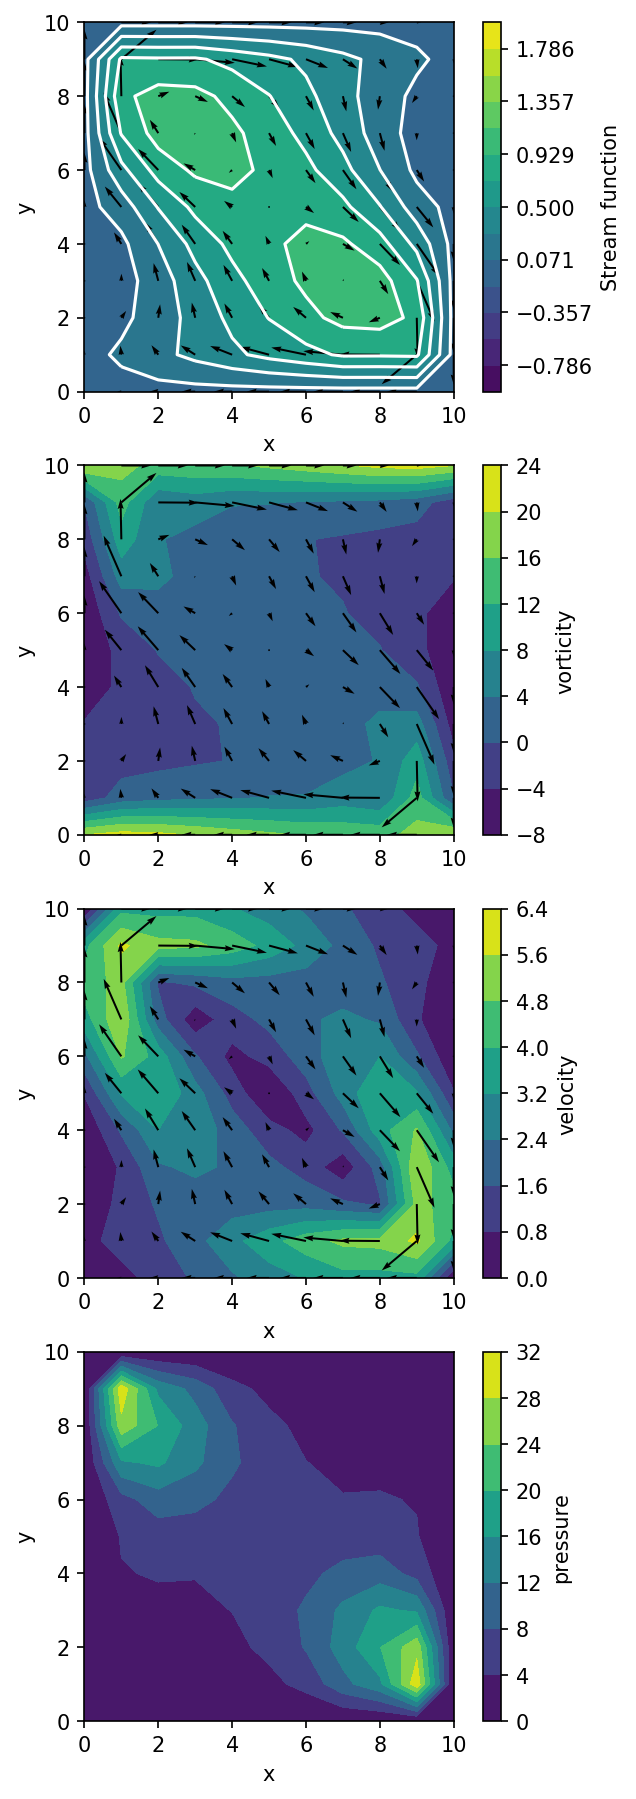

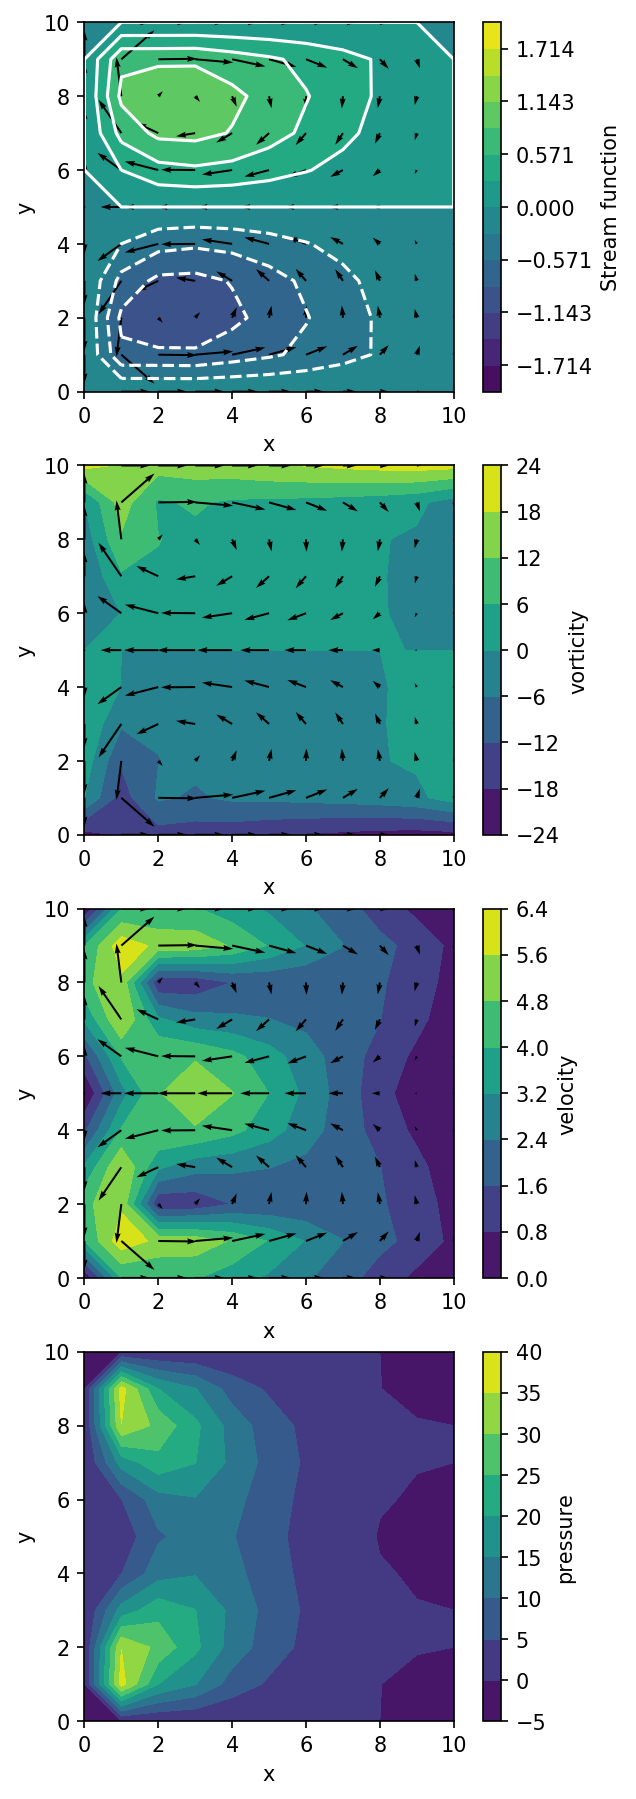

In [31]:
X, Y, U, W, V, P, v_x, v_y = solve_lid_driven_cavity_flow(Re=100, box_size = 100, u_bottom = 1.0)
create_plots(X, Y, U, W, V, P, v_x, v_y)

X, Y, U, W, V, P, v_x, v_y = solve_lid_driven_cavity_flow(Re=100, box_size = 100, u_bottom = -1.0)
create_plots(X, Y, U, W, V, P, v_x, v_y)